In [1]:
%%capture
import logging
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2
from src.log_config import configure_logging

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["numexpr", "numba", "bokeh", "matplotlib", "tornado", "Comm"],
)

In [2]:
import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import tomllib
from icecream import ic
from polars import col

from src.experiments.measurement.stimulus_generator import StimulusGenerator
from src.features.utils import to_describe
from src.plots.plot_stimulus import plot_stimulus, plot_stimulus_labels

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

In [3]:
def load_configuration(file_path: str) -> dict:
    """Load configuration from a TOML file."""
    file_path = Path(file_path)
    with open(file_path, "rb") as file:
        return tomllib.load(file)


config = load_configuration("src/experiments/measurement/measurement_config.toml")[
    "stimulus"
]


In [4]:
config = {
    "seeds": config["seeds"],
    "sample_rate": config["sample_rate"],
    "half_cycle_num": config["half_cycle_num"],
    "period_range": config["period_range"],
    "amplitude_range": config["amplitude_range"],
    "inflection_point_range": config["inflection_point_range"],
    "shorten_expected_duration": config["shorten_expected_duration"],
    "major_decreasing_half_cycle_num": config["major_decreasing_half_cycle_num"],
    "major_decreasing_half_cycle_period": config["major_decreasing_half_cycle_period"],
    "major_decreasing_half_cycle_amplitude": config[
        "major_decreasing_half_cycle_amplitude"
    ],
    "major_decreasing_half_cycle_min_y_intercept": config[
        "major_decreasing_half_cycle_min_y_intercept"
    ],
    "plateau_num": config["plateau_num"],
    "plateau_duration": config["plateau_duration"],
    "plateau_percentile_range": config["plateau_percentile_range"],
    "prolonged_minima_num": config["prolonged_minima_num"],
    "prolonged_minima_duration": config["prolonged_minima_duration"],
}
assert len(config["seeds"]) == len(set(config["seeds"])), "Seeds must be unique"
assert len(config["seeds"]) == 12, "There must be 12 seeds"

dummy_participant = {
    "temperature_baseline": 47.0,
    "temperature_range": 1.5,  # VAS 0 - VAS 70
}


dummy_config = {
    "seeds": [1, 2, 3],
    "half_cycle_num": 2,
    "period_range": [2, 2],
    "major_decreasing_half_cycle_num": 0,
    "shorten_expected_duration": 0,
    "amplitude_range": [0.9, 1.0],
    "plateau_num": 0,
    "prolonged_minima_num": 0,
}

# Plot one random seed
config.update(dummy_participant)
seed = np.random.randint(0, 1000)
stimulus = StimulusGenerator(config, debug=0, seed=467)

# print("Plot one random seed:")
plot_stimulus(stimulus, highlight_decreasing=True)

figure(id='f8efed84-6504-4b7c-b422-02ba1eccb52b', ...)

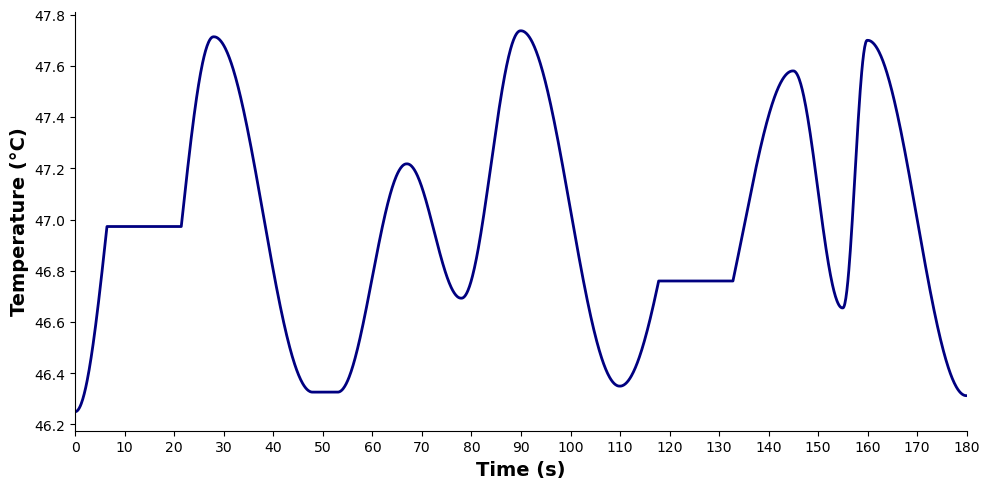

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='Time (s)', ylabel='Temperature (°C)'>)

In [6]:
import matplotlib.ticker as ticker
import numpy as np


def plot_stimulus_matplotlib(
    stimulus,
    filename: str = "Stimulus_Plot.png",
):
    """
    Plot the stimulus data using Matplotlib.
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 5))

    # Get time data
    time = np.array(range(len(stimulus.y))) / stimulus.sample_rate

    # Plot the main line
    ax.plot(time, stimulus.y, color="navy", linewidth=2)

    # Set title and labels
    ax.set_xlabel("Time (s)", fontweight="bold", fontsize=14)
    ax.set_ylabel("Temperature (°C)", fontweight="bold", fontsize=14)

    # Customize the plot
    ax.set_xlim(0, 180)

    # Set x-axis ticks every 10 seconds
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

    # Remove grid
    ax.grid(False)

    # Remove top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Tight layout
    plt.tight_layout()

    # Save the plot if a filename is provided
    if filename:
        plt.savefig(filename, dpi=300)

    # Show the plot
    plt.show()

    return fig, ax


# Example usage:
plot_stimulus_matplotlib(stimulus)

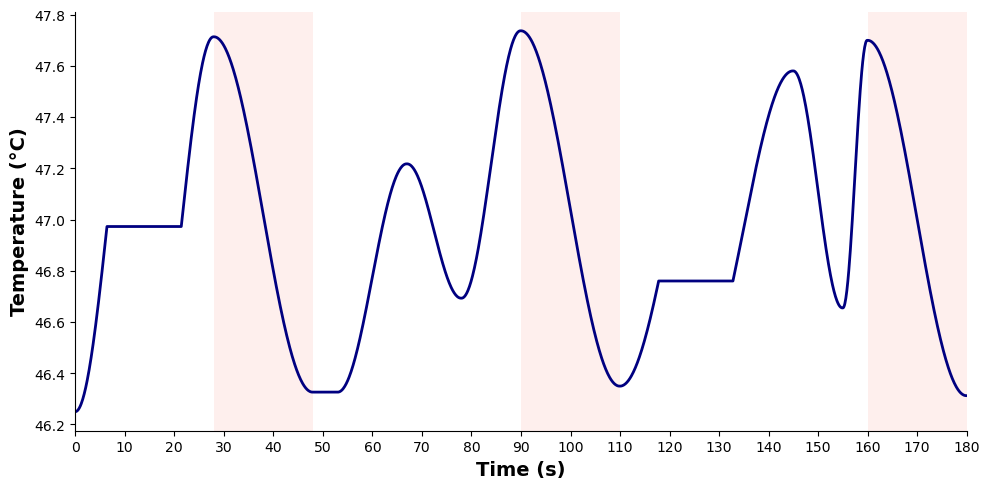

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='Time (s)', ylabel='Temperature (°C)'>)

In [ ]:
import matplotlib.patches as patches
import numpy as np


def plot_stimulus_matplotlib(
    stimulus,
    filename: str = "Stimulus_Plot.png",
    highlight_decreasing: bool = True,
):
    """
    Plot the stimulus data using Matplotlib.
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 5))

    # Get time data
    time = np.array(range(len(stimulus.y))) / stimulus.sample_rate

    # Plot the main line
    ax.plot(time, stimulus.y, color="navy", linewidth=2)

    # Add patches for the major decreasing intervals
    if highlight_decreasing:
        for interval in stimulus.major_decreasing_intervals_idx:
            start_time, end_time = (
                interval[0] / stimulus.sample_rate,
                interval[1] / stimulus.sample_rate,
            )
            ax.add_patch(
                patches.Rectangle(
                    (start_time, ax.get_ylim()[0]),
                    end_time - start_time,
                    ax.get_ylim()[1] - ax.get_ylim()[0],
                    facecolor="salmon",
                    alpha=0.125,
                    zorder=0,  # Place behind the line
                )
            )

    # Set title and labels
    ax.set_xlabel("Time (s)", fontweight="bold", fontsize=14)
    ax.set_ylabel("Temperature (°C)", fontweight="bold", fontsize=14)

    # Customize the plot
    ax.set_xlim(0, 180)

    # Set x-axis ticks every 10 seconds
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

    # Remove grid
    ax.grid(False)

    # Remove top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Tight layout
    plt.tight_layout()

    # Save the plot if a filename is provided
    if filename:
        plt.savefig(filename, dpi=300)

    # Show the plot
    plt.show()

    return fig, ax


# Example usage:
plot_stimulus_matplotlib(stimulus)

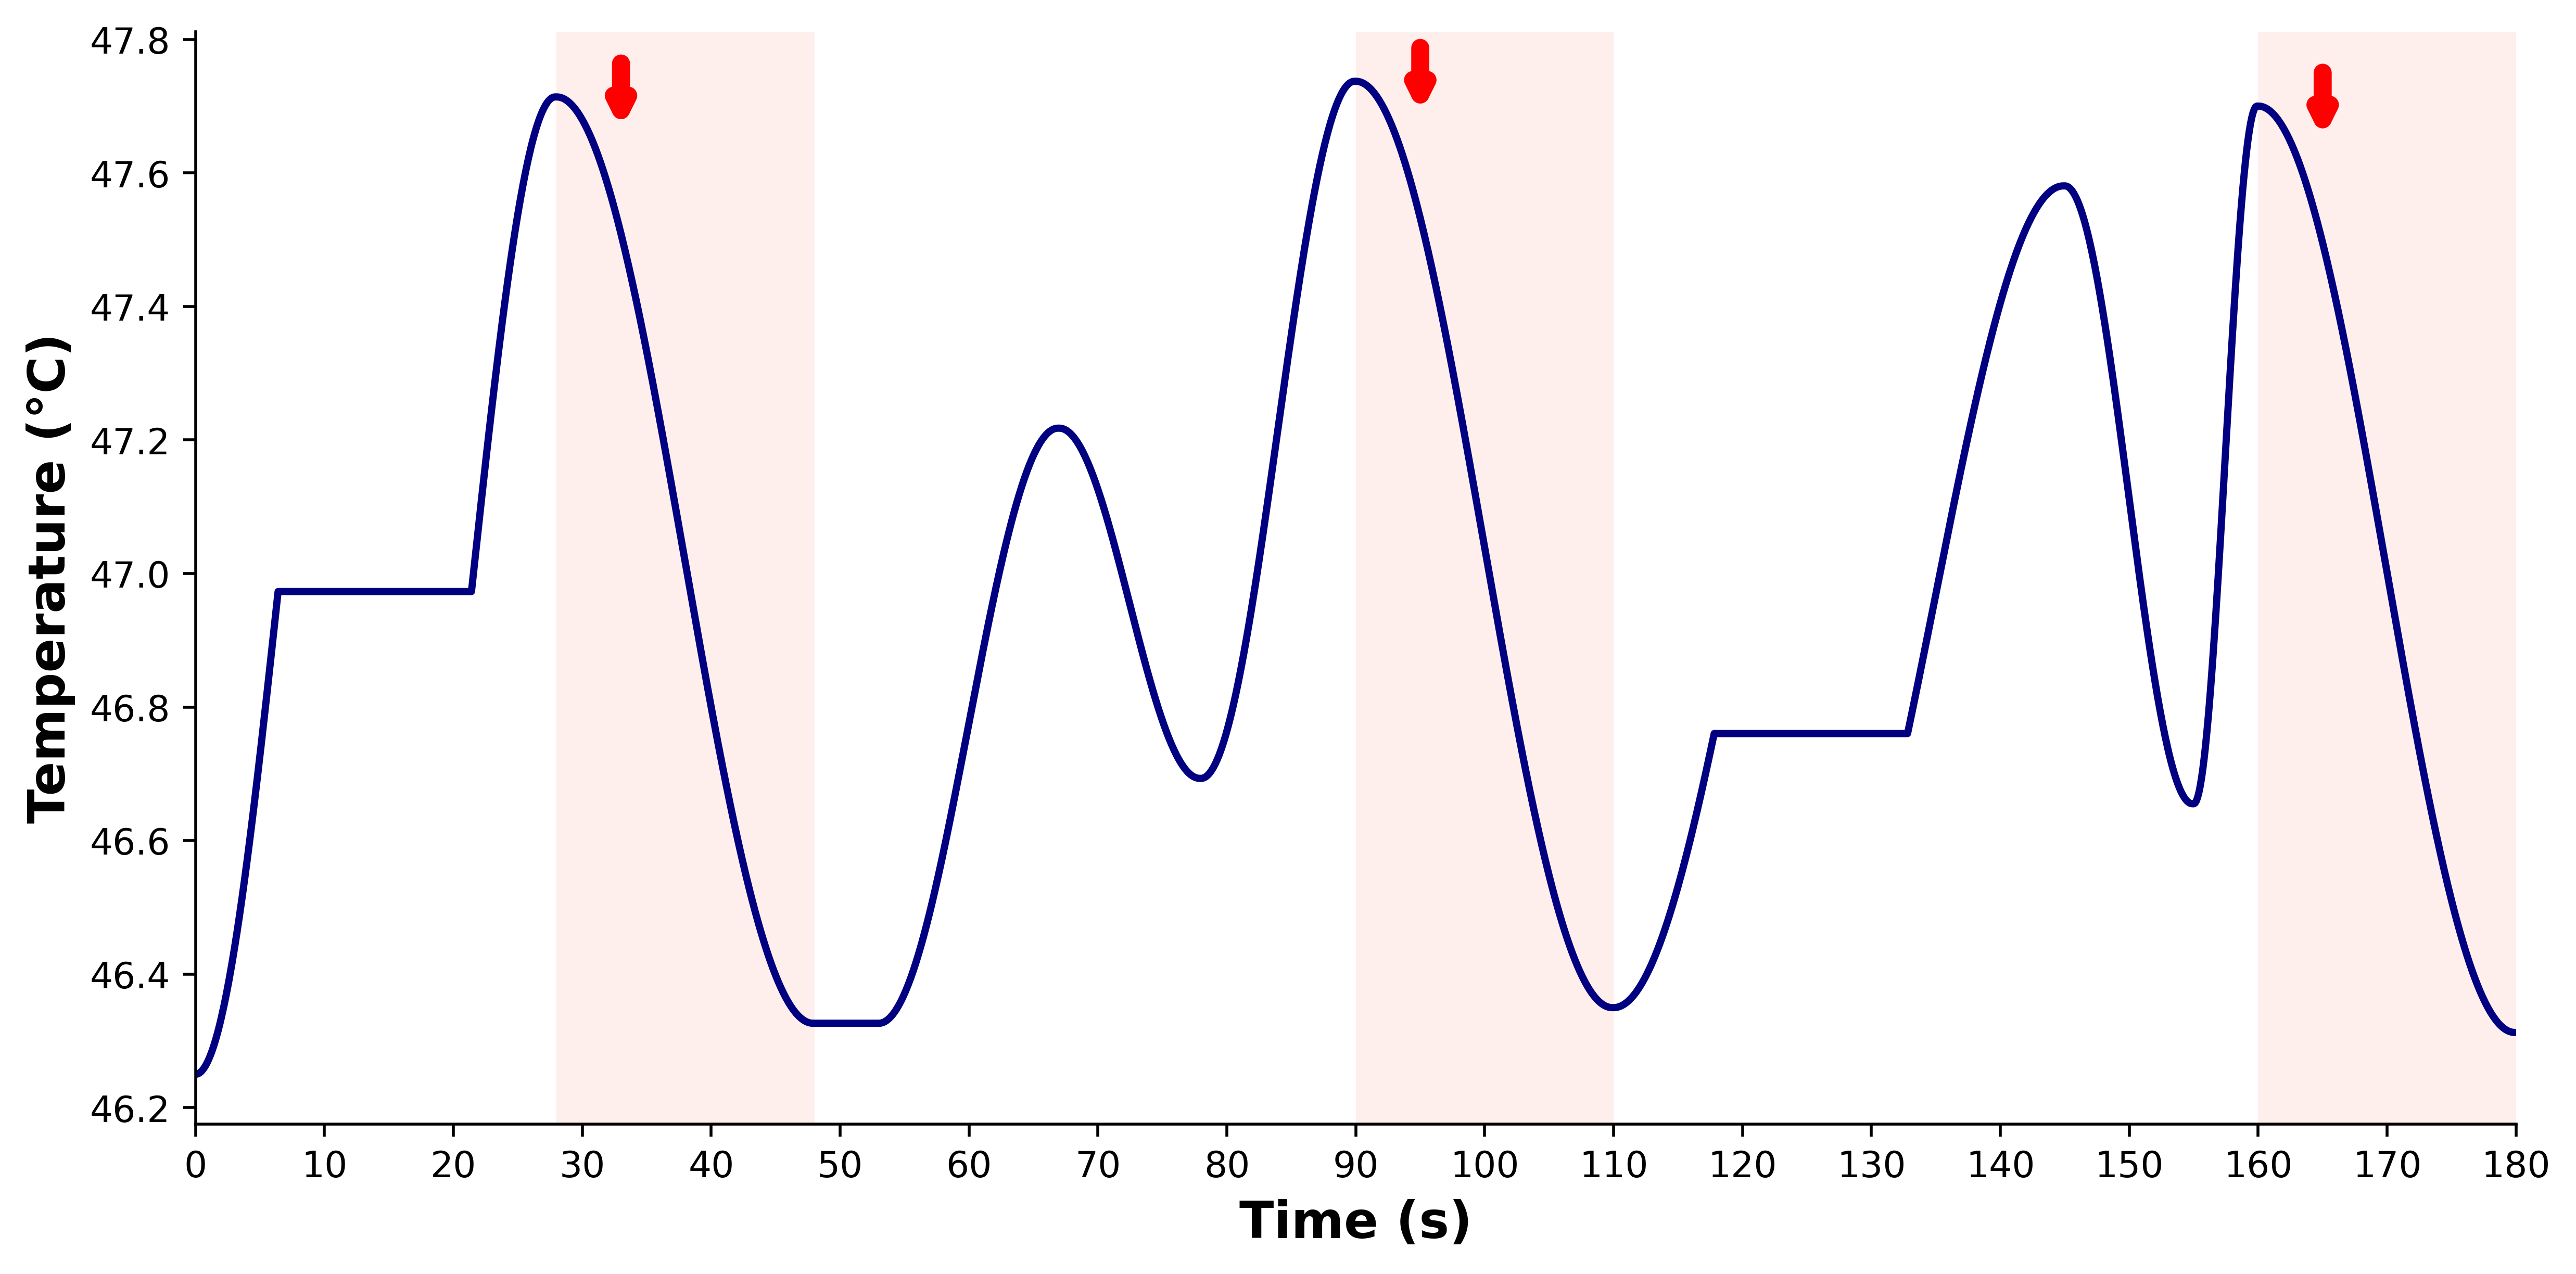

(<Figure size 5000x2500 with 1 Axes>,
 <Axes: xlabel='Time (s)', ylabel='Temperature (°C)'>)

In [ ]:
import numpy as np


def plot_stimulus_matplotlib(
    stimulus,
    filename: str = "Stimulus_Plot.png",
    highlight_decreasing: bool = True,
    show_arrows: bool = True,
):
    """
    Plot the stimulus data using Matplotlib.
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 5), dpi=500)

    # Get time data
    time = np.array(range(len(stimulus.y))) / stimulus.sample_rate

    # Plot the main line
    ax.plot(time, stimulus.y, color="navy", linewidth=2)

    # Add patches for the major decreasing intervals
    if highlight_decreasing:
        for interval in stimulus.major_decreasing_intervals_idx:
            start_time, end_time = (
                interval[0] / stimulus.sample_rate,
                interval[1] / stimulus.sample_rate,
            )
            ax.add_patch(
                patches.Rectangle(
                    (start_time, ax.get_ylim()[0]),
                    end_time - start_time,
                    ax.get_ylim()[1] - ax.get_ylim()[0],
                    facecolor="salmon",
                    alpha=0.125,
                    zorder=0,  # Place behind the line
                )
            )

    # Add red arrows at the start of major decreasing intervals
    if show_arrows:
        for interval in stimulus.major_decreasing_intervals_idx:
            start_idx = interval[0]
            start_time = start_idx / stimulus.sample_rate
            peak_temp = stimulus.y[start_idx]

            # Add arrow pointing down at the peak
            ax.annotate(
                "",
                xy=(start_time + 5, peak_temp - 0.05),  # Arrow tip
                xytext=(start_time + 5, peak_temp + 0.05),  # Arrow start
                arrowprops=dict(
                    arrowstyle="->", color="red", lw=5, shrinkA=0, shrinkB=0
                ),
                zorder=10,  # Place on top
            )

    # Set title and labels
    ax.set_xlabel("Time (s)", fontweight="bold", fontsize=14)
    ax.set_ylabel("Temperature (°C)", fontweight="bold", fontsize=14)

    # Customize the plot
    ax.set_xlim(0, 180)

    # Set x-axis ticks every 10 seconds
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

    # Remove grid
    ax.grid(False)

    # Remove top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Tight layout
    plt.tight_layout()

    # Save the plot if a filename is provided
    if filename:
        plt.savefig(filename, dpi=300)

    # Show the plot
    plt.show()

    return fig, ax


# Example usage:
plot_stimulus_matplotlib(stimulus)

## Show all stimuli

We want 12 seeds for unpredictable stimuli (note peak-and-end-rule)
- some with plateau in last peak
- some with low end temperature
- no mere sinosiodal patterns

In [5]:
stimulus.labels

{'decreasing_intervals': [(28000, 48000),
  (67000, 78000),
  (90000, 110000),
  (145000, 155000),
  (160000, 180000)],
 'major_decreasing_intervals': [(28000, 48000),
  (90000, 110000),
  (160000, 180000)],
 'increasing_intervals': [(0, 28000),
  (52900, 67000),
  (78000, 90000),
  (110000, 145000),
  (155000, 160000)],
 'strictly_increasing_intervals': [(21400, 28000),
  (52900, 67000),
  (78000, 90000),
  (132800, 145000),
  (155000, 160000)],
 'strictly_increasing_intervals_without_plateaus': [(52900, 67000),
  (78000, 90000),
  (155000, 160000)],
 'plateau_intervals': [(6400, 21400), (117800, 132800)],
 'prolonged_minima_intervals': [(47900, 52900)]}

In [6]:
stimuli = pl.concat(
    [
        pl.DataFrame(
            {
                "y": StimulusGenerator(config, seed).y,
                "time": np.arange(len(StimulusGenerator(config, seed).y)),
                "seed": np.array([seed] * len(StimulusGenerator(config, seed).y)),
            }
        )
        for seed in config["seeds"]
    ]
)

stimuli.hvplot(
    x="time",
    y="y",
    kind="line",
    groupby="seed",
    ylim=config["temperature_baseline"]
    + np.array([-1, 1]) * config["temperature_range"] / 2,
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'cfffc9c0-6f25-4a09-933f-f0d1b6fec999': {'version…

In [7]:
stimuli.group_by("seed", maintain_order=True).agg(to_describe("y"))

seed,y_count,y_null_count,y_mean,y_std,y_min,y_25%,y_50%,y_75%,y_max
i64,u32,u32,f64,f64,f64,f64,f64,f64,f64
133,1800,0,46.923677,0.421417,46.25,46.665601,46.77629,47.232711,47.746504
243,1800,0,46.936088,0.417877,46.25,46.628212,46.89741,47.273344,47.738635
265,1800,0,46.933886,0.440374,46.25,46.596208,46.779867,47.291213,47.744373
396,1800,0,46.970278,0.413692,46.25,46.728107,46.936483,47.308829,47.731835
467,1800,0,46.967071,0.419495,46.25,46.685108,46.972487,47.291938,47.737302
658,1800,0,46.96046,0.41285,46.25,46.621278,46.966524,47.264738,47.704574
681,1800,0,46.932364,0.407685,46.25,46.647874,46.942859,47.242448,47.739538
743,1800,0,46.963318,0.410683,46.25,46.715073,46.884511,47.289045,47.738548
806,1800,0,46.901926,0.438545,46.25,46.566414,46.72672,47.242545,47.749272


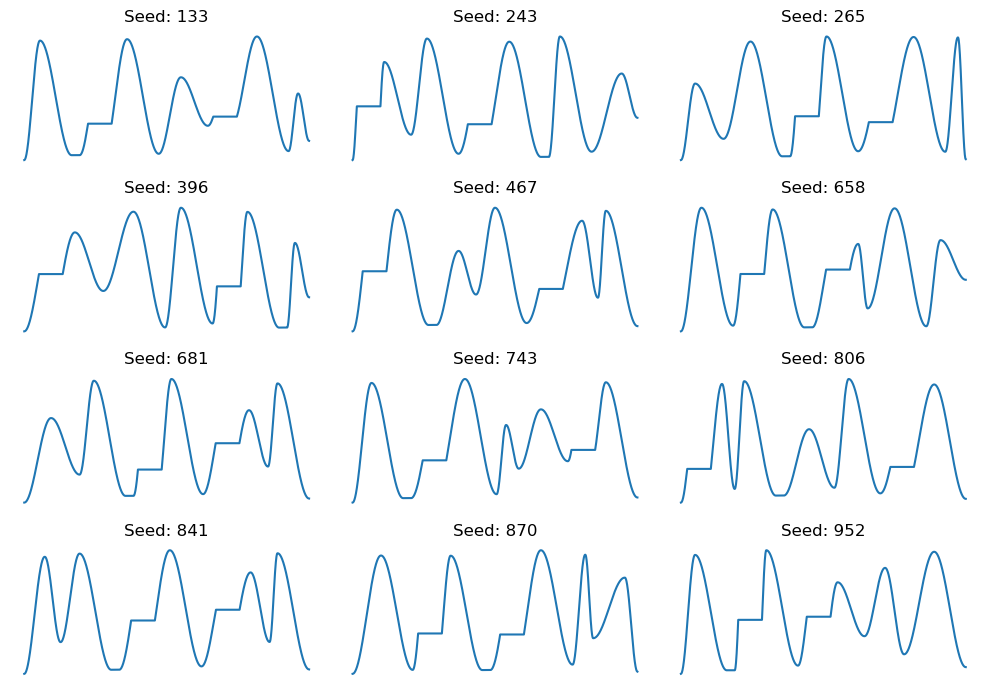

In [8]:
rows, cols = 4, 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 7))
axes = axes.flatten()

grouped = stimuli.group_by("seed", maintain_order=True).agg(col("time"), col("y"))
for i, row in enumerate(grouped.to_dicts()):
    ax = axes[i]
    ax.plot(row["time"], row["y"])
    ax.set_title(f"Seed: {row['seed']}")
    ax.axis(False)


plt.tight_layout()
plt.show()
# fig.savefig(
#     "/Users/visser/Dropbox/PhD/Dissertation/figures/stimulus_seeds.png", dpi=300
# )

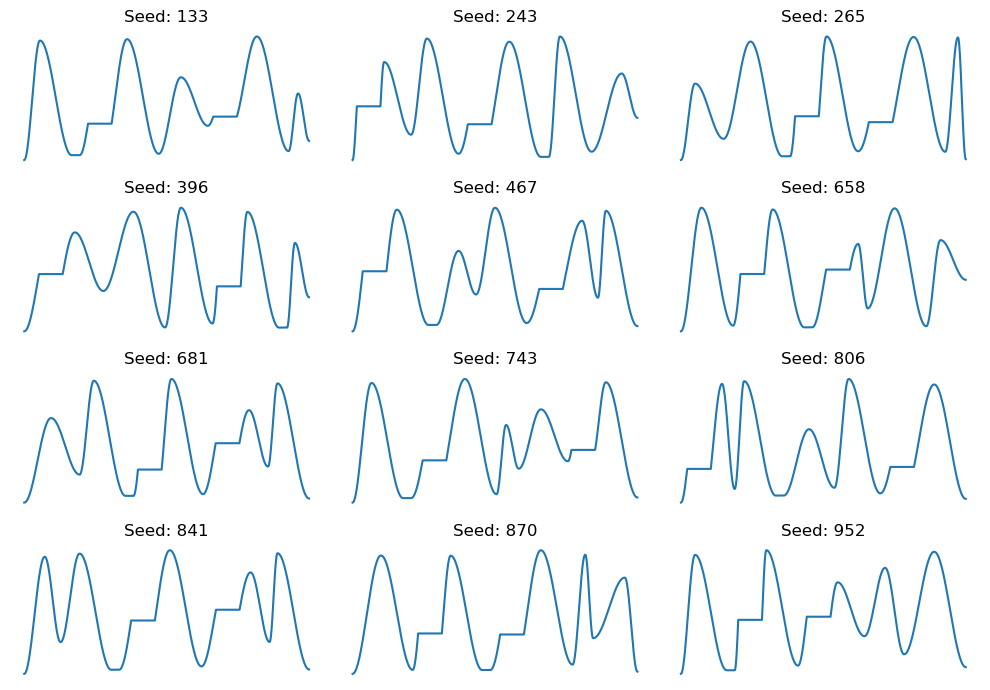

In [9]:
stim = StimulusGenerator(config, seed=467)
stim.duration

180.0

In [10]:
original_dict = {"a": 1, "b": 2, "c": 3}
{k: v for k, v in reversed(original_dict.items())}


{'c': 3, 'b': 2, 'a': 1}

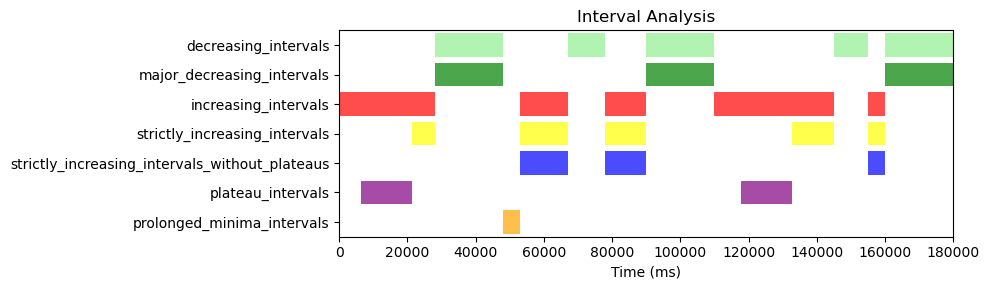

In [11]:
plot = plot_stimulus_labels(stim)

In [12]:
# save plot
# plot.savefig(
#     "/Users/visser/Dropbox/PhD/Dissertation/figures/stimulus_labels.png", dpi=300
# )